### 人工选择匹配角点

In [1]:
import cv2
import numpy as np

# 存储选点的列表
points_src = []
points_dst = []

# 鼠标回调函数
def select_points_src(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_src.append((x, y))
        cv2.circle(img_src_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Source Image", img_src_display)

def select_points_dst(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_dst.append((x, y))
        cv2.circle(img_dst_display, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow("Target Image", img_dst_display)

# 读取图像
img_src = cv2.imread(rf'G:\yansi0619\3D\aishangliaohou\ImageData_2025-06-19_16-55-50\rgb.bmp')  # 源图像（待变换图像）
img_dst = cv2.imread(rf'G:\yansi0619\spectral\data\aishangliohou\newdata20250619_165140.tiff')  # 目标图像（参考图像）

if img_src is None or img_dst is None:
    print("Error: Could not load images!")
    exit()

# 创建显示副本
img_src_display = img_src.copy()
img_dst_display = img_dst.copy()

# 创建窗口并设置回调
cv2.namedWindow("Source Image", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback("Source Image", select_points_src)

cv2.namedWindow("Target Image", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback("Target Image", select_points_dst)

print("请在源图像上选择至少4个点，按ESC继续")
while True:
    cv2.imshow("Source Image", img_src_display)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC键
        break

print("请在目标图像上选择对应点（相同顺序），按ESC继续")
while True:
    cv2.imshow("Target Image", img_dst_display)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC键
        break

cv2.destroyAllWindows()

# 检查点数
if len(points_src) < 4 or len(points_dst) < 4:
    print("错误：至少需要4个匹配点！")
    exit()

if len(points_src) != len(points_dst):
    print("错误：源图像和目标图像的点数不一致！")
    exit()

# 转换为NumPy数组
pts_src = np.array(points_src, dtype=np.float32)
pts_dst = np.array(points_dst, dtype=np.float32)

# 计算单应性矩阵（透视变换矩阵）
H, status = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)

if H is None:
    print("错误：无法计算变换矩阵！")
    exit()

# 应用透视变换
img_registered = cv2.warpPerspective(img_src, H, (img_dst.shape[1], img_dst.shape[0]))

# 创建匹配点可视化
img_matches = np.zeros((max(img_src.shape[0], img_dst.shape[0]), img_src.shape[1] + img_dst.shape[1], 3), dtype=np.uint8)
img_matches[0:img_src.shape[0], 0:img_src.shape[1]] = img_src
img_matches[0:img_dst.shape[0], img_src.shape[1]:] = img_dst

# 绘制匹配线
for i in range(len(points_src)):
    pt1 = (int(points_src[i][0]), int(points_src[i][1]))
    pt2 = (int(points_dst[i][0] + img_src.shape[1]), int(points_dst[i][1]))
    cv2.line(img_matches, pt1, pt2, (0, 255, 0), 1)
    cv2.circle(img_matches, pt1, 5, (0, 255, 0), -1)
    cv2.circle(img_matches, pt2, 5, (0, 0, 255), -1)

# 创建配准结果可视化
alpha = 0.5
blended = cv2.addWeighted(img_dst, alpha, img_registered, 1 - alpha, 0)

# 显示结果
cv2.imshow("Feature Matches", img_matches)
cv2.imshow("Registration Result", img_registered)
cv2.imshow("Overlay Result", blended)

print("按任意键退出...")
cv2.waitKey(0)
cv2.destroyAllWindows()

# 保存结果（可选）
cv2.imwrite("feature_matches.jpg", img_matches)
cv2.imwrite("registered_image.jpg", img_registered)
cv2.imwrite("overlay_result.jpg", blended)

请在源图像上选择至少4个点，按ESC继续
请在目标图像上选择对应点（相同顺序），按ESC继续
按任意键退出...


True

In [4]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import spectral
import glob


class ImgRegistration:
    def __init__(self, matrix_path, msi_board_path, rgb_board_path):
        self.matrix_path = matrix_path
        self.msi_board_path = msi_board_path
        self.rgb_board_path = rgb_board_path

    def get_rectify_M(self):
        """
        获取图像配准变换矩阵M
        1.显示特征匹配图片  2.显示模板图片对正效果图
        """
        msi = spectral.open_image(self.msi_board_path).load()
        spe_gray = (msi[:, :, 30] / 4).astype(np.uint8)
        RGB_img = cv.imdecode(np.fromfile(self.rgb_board_path, dtype=np.uint8), 0)
        rgb_gray = RGB_img
        sift = cv.SIFT_create()
        # 利用SIFT算法寻找特征点
        kp1, des1 = sift.detectAndCompute(spe_gray, None)
        kp2, des2 = sift.detectAndCompute(rgb_gray, None)
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Need to draw only good matches, so create a mask
        matchesMask = [[0, 0] for i in range(len(matches))]

        good = []
        pts1 = []
        pts2 = []
        # ratio test as per Lowe's paper
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.6 * n.distance:
                good.append(m)
                pts2.append(kp2[m.trainIdx].pt)
                pts1.append(kp1[m.queryIdx].pt)
                matchesMask[i] = [1, 0]

        draw_params = dict(matchColor=(0, 255, 0),
                           singlePointColor=(255, 0, 0),
                           matchesMask=matchesMask,
                           flags=0)
        img3 = cv.drawMatchesKnn(spe_gray, kp1, rgb_gray, kp2, matches, None, **draw_params)
        # plt.title('feature matching')
        # plt.imshow(img3)
        # plt.show()
        rows, cols = spe_gray.shape[:2]
        MIN_MATCH_COUNT = 10
        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        else:
            raise Exception("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        np.save(self.matrix_path, M)
        return 

    def rectify_msi(self, msi_floder_path , save_path):

        msi_path = glob.glob(f'{msi_floder_path}/*.hdr')
        M = np.load(self.matrix_path+'.npy')
        rgb_img = cv.imdecode(np.fromfile(self.rgb_board_path, dtype=np.uint8), 0)
        rows, cols = rgb_img.shape[:2]
        msi = spectral.open_image(msi_path[0]).load()
        msi_imgs = (msi / 4).astype(np.uint8)
        self.warpImgs = cv.warpPerspective(msi_imgs, np.linalg.inv(M), (cols, rows), flags=cv.WARP_INVERSE_MAP)
        
        for i in range(30):
         cv.imwrite(os.path.join(save_path , f'{i + 1}.png'), self.warpImgs[:, :, i])

        return 

In [5]:
# 帮我写了一个测试代码，你可以直接运行这个代码，看看效果
# 你需要修改的地方是，matrix_path，msi_board_path，rgb_board_path，save_path，msi_floder_path
# matrix_path是矩阵保存地址，msi_board_path是msi标定板地址，rgb_board_path是rgb标定板地址，save_path是保存地址，msi_floder_path是msi图像地址
matrix_path = r'D:\code\黄斑识别2'
msi_board_path = r'G:\peizhun\biaodingban-180236\2\biaodingban.hdr'
rgb_board_path = r'G:\peizhun\biaodingban-180236\2\biaodingban.png'

save_path = rf'G:\yellowspot_cigarette\dt\sdy-dt-203710\sdy-dt_20240617203710\2'
msi_floder_path =  save_path

reg  = ImgRegistration(matrix_path ,msi_board_path, rgb_board_path)
reg.get_rectify_M()
reg.rectify_msi(msi_floder_path , save_path)

# 得到reg类里面的全局变量warpImgs，是配准后的图像，输出warpImgs
reg.warpImgs.shape

C:\Users\dell\AppData\Roaming\Python\Python39\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(2048, 2448, 31)

In [ ]:
# 画个图
plt.imshow(reg.warpImgs[:,:,0])  # 0是第一个波段
plt.show()


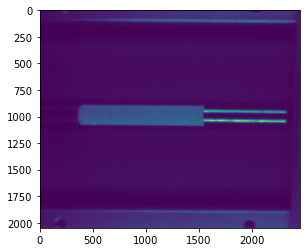

In [8]:
# plt显示warpImgs图像             
import matplotlib.pyplot as plt
plt.imshow(reg.warpImgs[:,:,10])   